In [1]:
import numpy as np
import matplotlib.pyplot as plt

import typing # So that I can write type signatures

# Probability Density Functions

In [2]:
def uniform_pdf(x: float) -> float:
    return 1 if 0 <= x < 1 else 0

In [3]:
SQRT_TWO_PI = np.sqrt(2 * np.pi)

In [5]:
# We take this straight from a statistics book
# this is an approximation of the PDF, it is missing weighting factor
def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (np.exp(-(x-mu) ** 2 / 2 / sigma ** 2) / (SQRT_TWO_PI * sigma))

Text(0.5, 1.0, 'A menagerie of normal distributions')

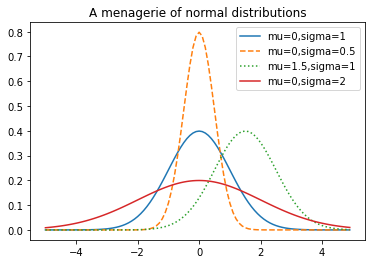

In [15]:
# Let's plot a bunch
xs = [x / 10.0 for x in range(-50,50)]

# Having a normal one
plt.plot(xs, [normal_pdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')

# Same mean, but more concentrated
plt.plot(xs, [normal_pdf(x,sigma=0.5) for x in xs],'--',label='mu=0,sigma=0.5')

# Different mean
plt.plot(xs, [normal_pdf(x,mu=1.5,sigma=1) for x in xs],':',label='mu=1.5,sigma=1')

# a wide boi
plt.plot(xs, [normal_pdf(x,sigma=2) for x in xs],'-',label='mu=0,sigma=2')

plt.legend()
plt.title("A menagerie of normal distributions")

# Back to the slides!
```


































```



























# Cumulative Density Functions

In [16]:
def uniform_cdf(x: float) -> float:
    if x < 0:   return 0
    elif x < 1: return x
    else:       return 1

Text(0.5, 1.0, 'Various Normal cdfs')

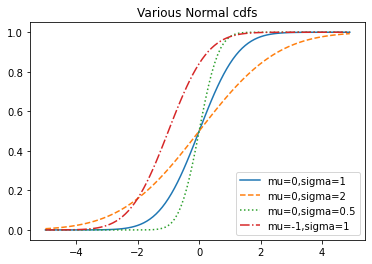

In [20]:
import math

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / np.sqrt(2) / sigma)) / 2

xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_cdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.plot(xs,[normal_cdf(x,sigma=2) for x in xs],'--',label='mu=0,sigma=2')
plt.plot(xs,[normal_cdf(x,sigma=0.5) for x in xs],':',label='mu=0,sigma=0.5')
plt.plot(xs,[normal_cdf(x,mu=-1) for x in xs],'-.',label='mu=-1,sigma=1')
plt.legend(loc=4) # bottom right
plt.title("Various Normal cdfs")